# CNN on Custom Images

For this exercise we're using a collection of Cats and Dogs images inspired by the classic Kaggle competition.

In the last section we downloaded the files, looked at the directory structure, examined the images, and
performed a variety of transforms in preparation for training.

In this section we'll define our model, then feed images through a training and validation sequence using
DataLoader.

### Perform standard imports

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision import datasets, transforms,models
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

### Define transforms

In the previous section we looked at a variety of transforms available for data augmentation (rotate, flip, etc.)
and normalization.

Here we'll combine the ones we want, including the recommended normalization parameters for mean and std
per channel.

In [3]:
# Transform the train data
train_transform = transforms.Compose([
    transforms.RandomRotation(10),  # rotate +/- 10 degree
    transforms.RandomHorizontalFlip(),# flip 50% of the image
    transforms.Resize(224), # resize shortest side to 224 pixels
    transforms.CenterCrop(224), # crop longest side to 224 pixel at center
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225])])

In [5]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

### Prepare train and test sets, loaders

We're going to take advantage of a built-in torchvision dataset tool called ImageFolder.

In [13]:
root ='data_cnn/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root,'train'), transform =train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'test'), transform =test_transform)

torch.manual_seed(42)

train_loader=DataLoader(train_data, batch_size = 10, shuffle=True)
test_loader=DataLoader(test_data, batch_size=10)
class_names = train_data.classes

In [14]:
class_names

['CAT', 'DOG']

### Display a batch of images

To verify that the training loader selects cat and dog images at random, let's show a batch of loaded images.
Recall that imshow clips pixel values <0, so the resulting display lacks contrast. We'll apply a quick inverse
transform to the input tensor so that images show their "true" colors.

In [15]:
for images, labels in train_loader:
    break

In [16]:
images.shape

torch.Size([10, 3, 224, 224])

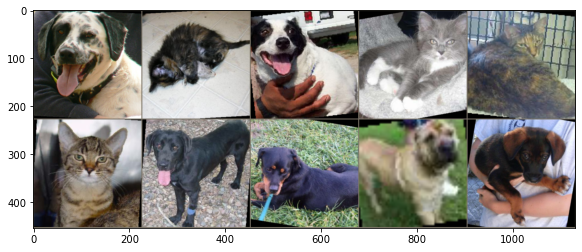

In [17]:
im = make_grid(images, nrow=5) # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
std=[1/0.229, 1/0.224, 1/0.225]
)

im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

### Define the model

We'll start by using a model similar to the one we applied to the CIFAR-10 dataset, except that here we have a
binary classification (2 output channels, not 10). Also, we'll add another set of convolution/pooling layers.

In [18]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 =nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,2)
    def forward(self, x):
        x= F.relu(self.conv1(x))
        x=F.max_pool2d(x,2,2)
        x= F.relu(self.conv2(x))
        x=F.max_pool2d(x,2,2)
        x=x.view(-1,54*54*16)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return F.log_softmax(x,dim=1)
    

### Instantiate the model, define loss and optimization functions
We're going to call our model "CNNmodel" to differentiate it from an "AlexNetmodel" we'll use later.

In [19]:
torch.manual_seed(101)
CNNmodel=ConvolutionalNetwork()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

### Check the number of parameters

In [21]:
for p in CNNmodel.parameters():
    print(p.numel())

162
6
864
16
5598720
120
10080
84
168
2


### Train the model

In the interests of time, we'll limit the number of training batches to 800, and the number of testing batches to
300. We'll train the model on 8000 of 18743 available images, and test it on 3000 out of 6251 images.

In [22]:
import time
start_time = time.time()
epochs = 2

max_trn_batch = 800 # 
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    # Run the training batches
    
    for b, (X_train, y_train) in enumerate(train_loader):
       
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
        
          # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
           # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
         # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2} batch: {b:4} [{10*b:6}/8000] loss: {loss.item():10.8f} \accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
      # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
          
          # Limit the number of batches
            if b == max_tst_batch:
                break
                
               # Apply the model
            y_val = CNNmodel(X_test)
            
             # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0 batch:  200 [  2000/8000] loss: 0.75371009 ccuracy:  57.650%
epoch:  0 batch:  400 [  4000/8000] loss: 0.47620860 ccuracy:  60.550%
epoch:  0 batch:  600 [  6000/8000] loss: 0.55036128 ccuracy:  62.050%
epoch:  0 batch:  800 [  8000/8000] loss: 0.58173639 ccuracy:  63.100%
epoch:  1 batch:  200 [  2000/8000] loss: 0.53968531 ccuracy:  64.450%
epoch:  1 batch:  400 [  4000/8000] loss: 0.53756332 ccuracy:  67.100%
epoch:  1 batch:  600 [  6000/8000] loss: 0.41171974 ccuracy:  68.217%
epoch:  1 batch:  800 [  8000/8000] loss: 0.95000333 ccuracy:  68.987%

Duration: 9160 seconds


### Save the trained model

In [23]:
torch.save(CNNmodel.state_dict(), 'CustomImagesCNNmodel.pt')

### Evaluate model performance

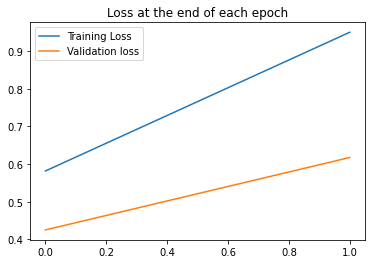

In [24]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()
         

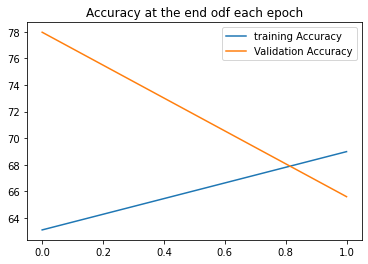

In [25]:
plt.plot([t/80 for t in train_correct], label = 'training Accuracy')
plt.plot([t/30 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy at the end odf each epoch')
plt.legend()
plt.show()

In [26]:
print(test_correct)
print(f'Test Accuracy: {test_correct[-1].item()*100/3000:.2f}%')


[tensor(2339), tensor(1968)]
Test Accuracy: 65.60%


### Download a pretrained model

Torchvision has a number of proven models available through torchvision.models:

* AlexNet
* VGG
* ResNet
* SqueezeNet
* DenseNet
* Inception
* GoogLeNet
* ShuffleNet
* MobileNet
* ResNeXt

</ul> These have all been trained on the ImageNet database of images. Our only task is to reduce the output
of the fully connected layers from (typically) 1000 categories to just 2.
To access the models, you can construct a model with random weights by calling its constructor:
resnet18 = models.resnet18()

You can also obtain a pre-trained model by passing pretrained=True:

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB
images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded
in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
Feel free to investigate the different models available. Each one will be downloaded to a cache directory the
first time they're accessed - from then on they'll be available locally.
For its simplicity and effectiveness, we'll use AlexNet:

In [28]:
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/bakary/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

This model uses torch.nn.AdaptiveAvgPool2d(output_size) to convert the large matrix coming out of
the convolutional layers to a (6x6)x256 matrix being fed into the fully connected layers.

### Freeze feature parameters

We want to freeze the pre-trained weights & biases. We set .requires_grad to False so we don't backprop
through them.

In [29]:
for param in AlexNetmodel.parameters():
    param.requires_grad=False

### Modify the classifier

Next we need to modify the fully connected layers to produce a binary output. The section is labeled "classifier"
in the AlexNet model.
Note that when we assign new layers, their parameters default to .requires_grad=True.

In [33]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216,1024),
                                       nn.ReLU(),
                                       nn.Dropout(0.4),
                                       nn.Linear(1024,2),
                                       nn.LogSoftmax(dim=1))

In [34]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

### Define loss function & optimizer

We only want to optimize the classifier parameters, as the feature parameters are frozen

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)


### Train the model

Remember, we're only training the fully connected layers. The convolutional layers have fixed weights and
biases. For this reason, we only need to run one epoch.

In [38]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
     # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
         # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
        
          # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
          # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
         # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2} batch: {b:4} [{10*b:6}/8000] loss: {loss.item():10.8f} \accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)
    
        # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break
                
              # Apply the model
            y_val = AlexNetmodel(X_test)
            
              # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0 batch:  200 [  2000/8000] loss: 0.21871141 ccuracy:  88.450%
epoch:  0 batch:  400 [  4000/8000] loss: 0.10956341 ccuracy:  90.600%
epoch:  0 batch:  600 [  6000/8000] loss: 0.19680698 ccuracy:  91.483%
epoch:  0 batch:  800 [  8000/8000] loss: 0.14343095 ccuracy:  92.287%

Duration: 8979 seconds


In [40]:
print(test_correct)
print(f'Test Accuracy: {test_correct[-1].item()*100/3000:.2f}%')

[tensor(2776)]
Test Accuracy: 92.53%


### Run a new image through the model

We can also pass a single image through the model to obtain a prediction.
Pick a number from 0 to 6250, assign it to "x", and we'll use that value to select an image from the Cats and
Dogs test set.

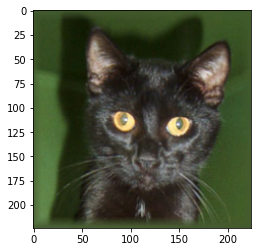

In [54]:
new_image = 100
im =inv_normalize(test_data[new_image][0])
plt.imshow(np.transpose(im.numpy(),(1,2,0)));

In [55]:
test_data[new_image][0].shape

torch.Size([3, 224, 224])

In [56]:
# CNN Model Prediction
CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_data[new_image][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 1 DOG


In [57]:
# AlexNet Model Prediction:
AlexNetmodel.eval()
with torch.no_grad():
    new_pred=AlexNetmodel(test_data[new_image][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')    

Predicted value: 0 CAT
